In [1]:
import elfi
import numpy as np
import torch

from dbo import likelihood, simulation
from dbo.lfi import RLSimulatorModel
from dbo.util import load_trajectories


In [2]:
def id_summary(y):
    return y

In [3]:
def data_distance(x,y, sigma = 1e-1):
    dist = np.linalg.norm((x-y)/sigma, axis=1, keepdims=True)
    return dist

In [4]:
env_id = "CartPole-v0"
likelihood_cov = 1e-1
trajectories_dir = "experiments/trajectories"

log_like = None
env_type = simulation.get_env_type(env_id)
real_obs_trajectories, real_actions_trajectories = load_trajectories(trajectories_dir, env_type)
n_real_trajectories = len(real_obs_trajectories)
assert n_real_trajectories > 0

if env_type == "CartPole":
    for i in range(n_real_trajectories):
        real_actions_trajectories[i] = np.array(real_actions_trajectories[i], dtype=np.int)

squeeze_actions = env_type in ["CartPole"]
n_params = 2

In [5]:
sim_model = RLSimulatorModel(real_obs_trajectories, real_actions_trajectories, env_id,
                             param_names=['masspole', 'length'],
                             squeeze_actions=squeeze_actions)

In [6]:
obs_stats = []
for target_obs_trajectory, actions_trajectory in zip(real_obs_trajectories, sim_model.action_trajectories):
    obs_stats += [likelihood.calculate_cross_correlation(target_obs_trajectory, actions_trajectory)]
obs_stats = np.stack(obs_stats).ravel()

In [7]:
elfi.new_model()
sim_prior = elfi.Prior('normal', 0, 1, size=n_params, name='param')
# Add the simulator node and observed data to the model
sim = elfi.Simulator(sim_model, sim_prior, observed=obs_stats.reshape(1,-1), name='sim')

# Add summary statistics to the model
summary = elfi.Summary(id_summary, sim)

# Specify distance as euclidean between summary vectors (S1, S2) from simulated and
# observed data
dist = elfi.Distance(data_distance, summary, name='distance')

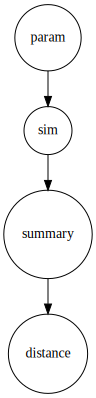

In [8]:
elfi.draw(dist)

In [9]:
sampler = elfi.Rejection(dist, batch_size=1)

In [10]:
n_samples = 1000
# schedule = [0.7, 0.2, 0.05]
%time res = sampler.infer(n_samples)

Progress [==================================================] 100.0% Complete
CPU times: user 6min 31s, sys: 5.68 s, total: 6min 37s
Wall time: 6min 25s


In [13]:
samples = res.samples['param']

[-3, 3, -3, 3]

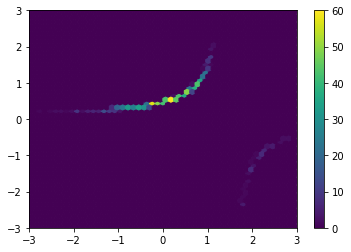

In [19]:
import matplotlib.pyplot as plt

extent = [-3, 3, -3, 3]
plt.hexbin(samples[:, 0], samples[:, 1], gridsize=50, extent=extent)
plt.colorbar()
plt.axis(extent)

In [24]:
from dbo.util import save_object

save_object("experiments/ABC-result-CartPole-Gaussian-prior.pkl", res)